In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, balanced_accuracy_score,
    matthews_corrcoef, roc_auc_score, RocCurveDisplay,
    precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression, SGDClassifier

# Pro reprodukovatelnost
np.random.seed(42)
RSTATE = 42

# Supervised Learning — Classification

## What is Classification?

Classification is the second fundamental task in **supervised learning**. Its goal is to **predict a discrete category (class)**.

Unlike *regression*, which predicts a continuous value (e.g., 25.5 °C), classification answers questions such as “Yes/No,” “Which type?”, or “Does it belong here?”

* **Binary classification:** Predicts one of two classes (e.g., `0` vs `1`, `Spam` vs `Not Spam`, `Malignant tumor` vs `Benign`).
* **Multi-class classification:** Predicts one of many classes (e.g., `Dog` vs `Cat` vs `Bird`, `Handwritten digits 0–9`).

In this exercise, we will focus on **binary classification** and build one of the oldest and most famous models: **Rosenblatt’s Perceptron**.

The goal is to find a **decision boundary** (in 2D, a straight line) that best separates the points of one class from those of the other.


## Mathematical background (Perceptron)

The perceptron is a type of linear classifier. It works in two steps:

### 1. Compute the “score”
Just like in linear regression, the model first computes a weighted sum of the inputs \(x_i\) and adds a bias \(b\). We call this raw value the score \(s_i\).
$$
s_i = w^\top x_i + b
$$
* If \(s_i\) is a **large positive number**, the model is “confident” the sample belongs to class +1.
* If \(s_i\) is a **large negative number**, the model is “confident” the sample belongs to class −1.
* If \(s_i\) is **close to zero**, the sample lies near the decision boundary.

### 2. Activation function (Step Function)
To obtain the final class prediction (e.g., `0` or `1`), we pass the score \(s_i\) through a **step activation function**.  
For predicting classes \(\{-1, +1\}\) we use the \(\text{sign}\) function:
$$
\hat{y}_i = \text{sign}(s_i) = \begin{cases}
      +1 & \text{if } s_i \ge 0 \\
      -1 & \text{if } s_i < 0
   \end{cases}
$$
(For classes \(\{0,1\}\), we would use \(\hat{y}_i = 1\) if \(s_i \ge 0\), otherwise \(0\).)

### 3. Training (Perceptron Learning Rule)
The perceptron learns using a procedure similar to **Stochastic Gradient Descent (SGD)**. It processes the data sample by sample.

* If the prediction \(\hat{y}_i\) is **correct** (i.e., \(\hat{y}_i = y_i\)), **nothing happens**.
* If the prediction \(\hat{y}_i\) is **incorrect** (i.e., \(\hat{y}_i \ne y_i\)), the model **immediately updates the weights**:

For learning rate \(\eta\) and target \(y_i \in \{-1, +1\}\):
$$
w \leftarrow w + \eta \cdot (y_i - \hat{y}_i) \cdot x_i
$$
$$
b \leftarrow b + \eta \cdot (y_i - \hat{y}_i)
$$

(Note: Because \((y_i - \hat{y}_i)\) is always \(\pm 2\), this is often simplified to  
\( w \leftarrow w + \eta \cdot y_i \cdot x_i \) for \(y_i \in \{-1,+1\}\) if \(\eta\) absorbs the constant. We will keep the more general form, which also works for 0/1 labels.)

**Important property:** The perceptron is guaranteed to find a solution (converge) **if and only if** the data are **linearly separable** (i.e., there exists a straight line that separates the classes). If the data are not linearly separable, the algorithm will keep “jumping” around forever without convergence.

$$\phantom{}$$


In [2]:
class PerceptronClassifier:
    """
    Implementation of Rosenblatt's perceptron.

    Trained using an "online" (stochastic) method, i.e., sample by sample.
    Accepts target labels as {0, 1}, but internally works with {-1, +1}.
    """

    def __init__(self, n_epochs: int = 100, lr: float = 0.01,
                 fit_intercept: bool = True,
                 early_stopping_patience: int = 15):
        """
        Initialize hyperparameters.

        n_epochs: Maximum number of epochs (full passes over the data)
        lr: Learning rate
        fit_intercept: Whether to learn 'b' (bias/intercept)
        early_stopping_patience: Number of epochs without improvement on the
                                 validation set before training stops.
        """
        self.n_epochs = n_epochs
        self.lr = lr
        self.fit_intercept = fit_intercept
        self.early_stopping_patience = early_stopping_patience

        self.w = None
        self.b = 0.0
        # We can also store the error history for debugging/tuning
        self.errors_history = []

    def fit(self, X: np.ndarray, y: np.ndarray,
            X_val: np.ndarray = None, y_val: np.ndarray = None):
        """
        Train the model on (X, y), optionally using (X_val, y_val)
        for early stopping.

        y: Expects labels {0, 1}
        """
        n, d = X.shape
        self.w = np.zeros(d, dtype=float)
        self.b = 0.0

        # Convert labels from {0, 1} to {-1, +1} for training
        y_pm = np.where(y == 1, 1, -1)

        # --- Early Stopping setup ---
        use_es = X_val is not None and y_val is not None
        best_val_acc = -np.inf
        patience_counter = 0
        best_w = self.w.copy()
        best_b = self.b
        # ----------------------------

        print(f"Perceptron training starts (max {self.n_epochs} epochs, lr={self.lr})...")

        for epoch in range(self.n_epochs):
            errors_in_epoch = 0

            # Training proceeds sample-by-sample (Stochastic/Online)
            for xi, target in zip(X, y_pm):
                # 1. Compute score
                s = float(np.dot(self.w, xi) + (self.b if self.fit_intercept else 0.0))

                # 2. Prediction via step function
                y_hat = 1 if s >= 0.0 else -1

                # 3. Update weights ONLY when misclassified
                if y_hat != target:
                    errors_in_epoch += 1
                    # Update rule: w = w + lr * y_i * x_i
                    # (y_i is 'target', which is -1 or +1)
                    upd = self.lr * target
                    self.w += upd * xi
                    if self.fit_intercept:
                        self.b += upd

            self.errors_history.append(errors_in_epoch)

            # --- Early Stopping check (end of epoch) ---
            if use_es:
                # For ES we must use .predict(), which returns {0, 1}
                val_acc = accuracy_score(y_val, self.predict(X_val))

                if val_acc > best_val_acc + 1e-4:  # Tolerance for improvement
                    best_val_acc = val_acc
                    best_w = self.w.copy()
                    best_b = self.b
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= self.early_stopping_patience:
                    print(f"INFO: Early stopping at epoch {epoch + 1} (Val Acc: {best_val_acc:.4f})")
                    break
            # -------------------------------------------

        # --- End of training ---
        if use_es:
            print(f"INFO: Training finished. Restoring model from epoch {epoch + 1 - patience_counter}.")
            self.w = best_w
            self.b = best_b
        else:
            print("INFO: Training finished (reached max epochs).")

        return self

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        """
        Return the raw score (before the activation function).
        This is key for computing ROC–AUC.
        """
        if self.w is None:
            raise RuntimeError("Model is not trained. Call 'fit' first.")

        return X @ self.w + (self.b if self.fit_intercept else 0.0)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Perform final classification on new data X.
        Returns labels {0, 1}.
        """
        # Compute scores
        scores = self.decision_function(X)

        # Apply the step function and convert to int (0 or 1)
        return (scores >= 0.0).astype(int)


## Data Preparation (Classification)

For classification, we will generate 2D data using `make_blobs`.  
This will create two “clusters” of points that represent our two classes (`0` and `1`).

### Key Concept: Stratification

When splitting data into `train`, `validation`, and `test` sets, it is **extremely important** in classification tasks to use **stratification**.

**The Problem:**  
Imagine you have a dataset with 100 samples, where 90 belong to class `A` and only 10 to class `B` (an *imbalanced dataset*).  
If you split the data randomly, it could happen that *all* samples of class `B` end up in the training set — leaving **zero samples of class `B`** in the test set.  
In that case, your test performance metric would be meaningless.

**The Solution (Stratification):**  
The argument `stratify=y` in `train_test_split` ensures that the **class proportions remain the same** in the training, validation, and test sets.

As always, we also **standardize** the data so that both the Perceptron model and `StandardScaler` work under consistent, well-scaled inputs.


In [3]:
# 1. Data generation
# Create 500 points split into 2 centers (classes)
# cluster_std=1.6: How dispersed the points are
X_cls, y_cls = make_blobs(n_samples=500, centers=2, cluster_std=1.6,
                          random_state=RSTATE, center_box=(-5, 5))

# 2. Split into Train (60%), Validation (20%), Test (20%)
# We use stratify=y_cls and stratify=yc_tmp to preserve class proportions

# Step 1: Train (60%) and Temporary (40%)
Xc_tr, Xc_tmp, yc_tr, yc_tmp = train_test_split(
    X_cls, y_cls, test_size=0.4, random_state=RSTATE, stratify=y_cls
)

# Step 2: Validation (20%) and Test (20%)
Xc_va, Xc_te, yc_va, yc_te = train_test_split(
    Xc_tmp, yc_tmp, test_size=0.5, random_state=RSTATE, stratify=yc_tmp
)

print("--- Dataset shapes (Classification) ---")
print(f"Train:      {Xc_tr.shape}, {yc_tr.shape}")
print(f"Validation: {Xc_va.shape}, {yc_va.shape}")
print(f"Test:       {Xc_te.shape}, {yc_te.shape}")

# Verify stratification (percentage of class 1)
print("\n--- Stratification check (% of class 1) ---")
print(f"Overall:    {np.mean(y_cls):.2f}")
print(f"Train:      {np.mean(yc_tr):.2f}")
print(f"Validation: {np.mean(yc_va):.2f}")
print(f"Test:       {np.mean(yc_te):.2f}")

# 3. Standardization (Scaling) of data
# Fit the scaler ONLY on the training data (Xc_tr)
sc_c = StandardScaler().fit(Xc_tr)

# Apply the trained scaler to all splits
Xc_tr_s = sc_c.transform(Xc_tr)
Xc_va_s = sc_c.transform(Xc_va)
Xc_te_s = sc_c.transform(Xc_te)


--- Dataset shapes (Classification) ---
Train:      (300, 2), (300,)
Validation: (100, 2), (100,)
Test:       (100, 2), (100,)

--- Stratification check (% of class 1) ---
Overall:    0.50
Train:      0.50
Validation: 0.50
Test:       0.50


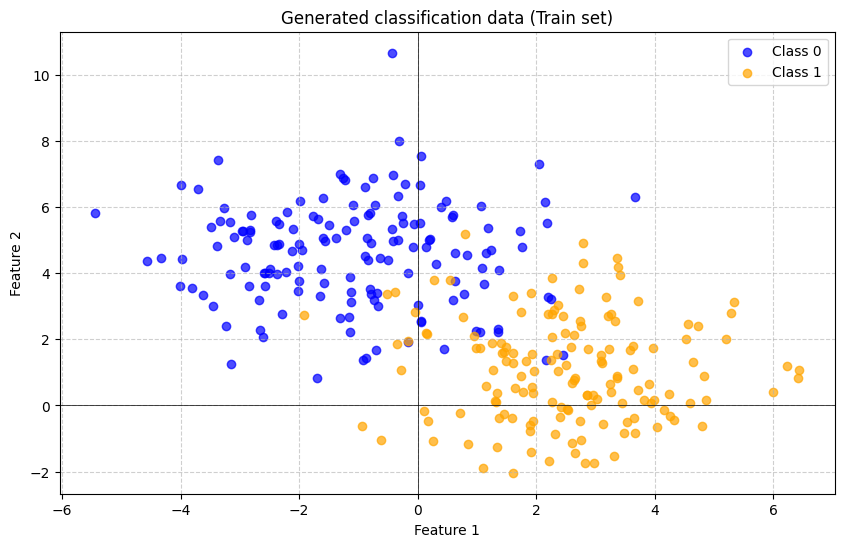

In [4]:
# Data visualization

# Plot the training set (before scaling)
plt.figure(figsize=(10, 6))

# Plot each class separately
plt.scatter(Xc_tr[yc_tr == 0][:, 0], Xc_tr[yc_tr == 0][:, 1],
            c='blue', label='Class 0', alpha=0.7)
plt.scatter(Xc_tr[yc_tr == 1][:, 0], Xc_tr[yc_tr == 1][:, 1],
            c='orange', label='Class 1', alpha=0.7)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated classification data (Train set)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.show()


In [5]:
# Training and evaluating the model

# 1. Initialize the model
# n_epochs=500: Set a high maximum; Early Stopping will likely stop earlier.
# lr=0.01: Relatively small learning rate for more stable convergence.
# early_stopping_patience=20: Stop training if Validation Accuracy
#                              does not improve for 20 consecutive epochs.
clf = PerceptronClassifier(
    n_epochs=500,
    lr=0.01,
    early_stopping_patience=20
)

# 2. Train the model
# Train on scaled training data (Xc_tr_s, yc_tr)
# and use scaled validation data (Xc_va_s, yc_va) for Early Stopping.
clf.fit(Xc_tr_s, yc_tr, X_val=Xc_va_s, y_val=yc_va)

# 3. Predictions on the TEST set
# Final class predictions (returns 0 or 1)
yc_pred_te = clf.predict(Xc_te_s)
# Raw scores (needed for ROC–AUC)
scores_te = clf.decision_function(Xc_te_s)


# 4. Evaluation on the TEST set
print("\n" + "---" * 15)
print("Final performance on the TEST set:")
print("---" * 15)

# Basic metrics
acc  = accuracy_score(yc_te, yc_pred_te)
prec = precision_score(yc_te, yc_pred_te, zero_division=0)
rec  = recall_score(yc_te, yc_pred_te, zero_division=0)
f1   = f1_score(yc_te, yc_pred_te, zero_division=0)

# Advanced metrics
bal_acc = balanced_accuracy_score(yc_te, yc_pred_te)
mcc = matthews_corrcoef(yc_te, yc_pred_te)
# ROC–AUC must be computed from raw scores, not hard 0/1 predictions
roc_auc = roc_auc_score(yc_te, scores_te)

print(f"Accuracy:          {acc:.3f}")
print(f"Precision:         {prec:.3f} (Positive Predictive Value for class 1)")
print(f"Recall:            {rec:.3f} (Sensitivity/True Positive Rate for class 1)")
print(f"F1 Score:          {f1:.3f} (Harmonic mean of Precision and Recall)")
print("---")
print(f"Balanced Accuracy: {bal_acc:.3f} (Better for imbalanced data)")
print(f"Matthews CC:       {mcc:.3f} (Robust metric, range -1 to +1)")
print(f"ROC–AUC:           {roc_auc:.3f} (Area under the ROC curve)")

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(yc_te, yc_pred_te)
print(cm)
print(f"(True Negatives predicted as Negative: {cm[0, 0]})")
print(f"(True Positives predicted as Positive: {cm[1, 1]})")

# Classification Report (compact summary)
print("\n--- Classification Report ---")
report = classification_report(yc_te, yc_pred_te, digits=3, zero_division=0)
print(report)


Perceptron training starts (max 500 epochs, lr=0.01)...
INFO: Early stopping at epoch 30 (Val Acc: 0.9400)
INFO: Training finished. Restoring model from epoch 10.

---------------------------------------------
Final performance on the TEST set:
---------------------------------------------
Accuracy:          0.950
Precision:         1.000 (Positive Predictive Value for class 1)
Recall:            0.900 (Sensitivity/True Positive Rate for class 1)
F1 Score:          0.947 (Harmonic mean of Precision and Recall)
---
Balanced Accuracy: 0.950 (Better for imbalanced data)
Matthews CC:       0.905 (Robust metric, range -1 to +1)
ROC–AUC:           0.994 (Area under the ROC curve)

--- Confusion Matrix ---
[[50  0]
 [ 5 45]]
(True Negatives predicted as Negative: 50)
(True Positives predicted as Positive: 45)

--- Classification Report ---
              precision    recall  f1-score   support

           0      0.909     1.000     0.952        50
           1      1.000     0.900     0.947   

## Explanation of Classification Metrics

With regression, evaluation was straightforward (RMSE, R²).  
For classification, evaluation is more complex and **the choice of metric depends on the problem you are solving**.

All classification metrics (except ROC–AUC) are derived from the **Confusion Matrix**.

### Confusion Matrix Terms

* **True Positive (TP):** Actual = `1` (Positive), model predicted `1` (hit).
* **True Negative (TN):** Actual = `0` (Negative), model predicted `0` (hit).
* **False Positive (FP) / Type I Error:** Actual = `0`, model predicted `1`  
  (false alarm — e.g., a legitimate email marked as spam).
* **False Negative (FN) / Type II Error:** Actual = `1`, model predicted `0`  
  (miss — e.g., a spam email delivered to inbox, or cancer labeled as benign).

---

### Basic Metrics

* **Accuracy:** $\frac{TP + TN}{TP + TN + FP + FN}$  
  * **Meaning:** “What percentage of all predictions were correct?”  
  * **Issue:** **Misleading on imbalanced data.**  
    Example: if 99% of samples are class `A`, a model always predicting `A` will have 99% accuracy and still be useless.

* **Precision (for class 1):** $\frac{TP}{TP + FP}$  
  * **Meaning:** “Of all samples predicted as Positive (`1`), how many truly were Positive?”  
  * **When important:** Avoiding **False Positives (FP)**.  
  * **Example:** Spam filter — high precision means very few important emails are wrongly flagged.

* **Recall (Sensitivity):** $\frac{TP}{TP + FN}$  
  * **Meaning:** “Of all true Positive samples, how many did the model detect?”  
  * **When important:** Avoiding **False Negatives (FN)**.  
  * **Example:** Cancer screening — better to flag extra healthy people than miss one sick patient.

* **F1-Score:**  
  $$
  2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$  
  * **Meaning:** Harmonic mean of Precision and Recall. Good when you need **balance** between them.

---

### Advanced Metrics

* **Balanced Accuracy:**  
  $$
  \frac{\text{Recall for class 0} + \text{Recall for class 1}}{2}
  $$  
  * **Meaning:** Average detection rate across both classes. Much better than Accuracy for **imbalanced data**.

* **Matthews Correlation Coefficient (MCC):**  
  * **Meaning:** A correlation-like score using TP, TN, FP, FN.  
  * **Interpretation:**  
    * `+1`: perfect classifier  
    * `0`: random guessing  
    * `-1`: perfectly wrong (inverse predictions)  
  * **Strength:** One of the most robust metrics for imbalanced classification.

* **ROC–AUC:** (see next section)  
  * **Meaning:** “Probability that the model assigns a higher **score** to a random Positive than to a random Negative.”  
  * **Note:** Evaluates **ranking ability**, not just hard 0/1 predictions.  
  * `1.0` = perfect, `0.5` = random.

$$\phantom{}$$


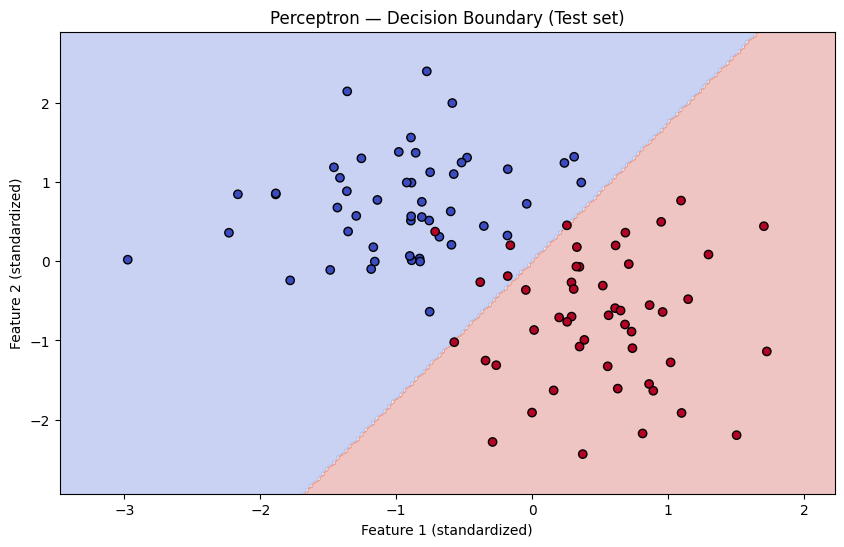

In [6]:
## Decision Boundary

# Setup for plotting the boundary
# Create a grid of points covering the whole plot area
x0_min, x0_max = Xc_te_s[:, 0].min() - 0.5, Xc_te_s[:, 0].max() + 0.5
x1_min, x1_max = Xc_te_s[:, 1].min() - 0.5, Xc_te_s[:, 1].max() + 0.5

# np.meshgrid creates coordinates for every point in the grid
xx0, xx1 = np.meshgrid(
    np.linspace(x0_min, x0_max, 200),
    np.linspace(x1_min, x1_max, 200)
)

# Create one large 2D array from all grid points
grid_points = np.c_[xx0.ravel(), xx1.ravel()]

# Compute prediction (0 or 1) for every grid point
zz = clf.predict(grid_points).reshape(xx0.shape)

# --- Plotting ---
plt.figure(figsize=(10, 6))

# 1. Plot colored “zones” of predictions
# contourf fills the area with colors according to values in 'zz'
plt.contourf(xx0, xx1, zz, alpha=0.3, cmap=plt.cm.coolwarm)

# 2. Plot test points
# (c=yc_te) colors points by their TRUE class
plt.scatter(Xc_te_s[:, 0], Xc_te_s[:, 1], c=yc_te,
            cmap=plt.cm.coolwarm, edgecolors='k', label="Test data")

plt.xlabel("Feature 1 (standardized)")
plt.ylabel("Feature 2 (standardized)")
plt.title("Perceptron — Decision Boundary (Test set)")
plt.show()


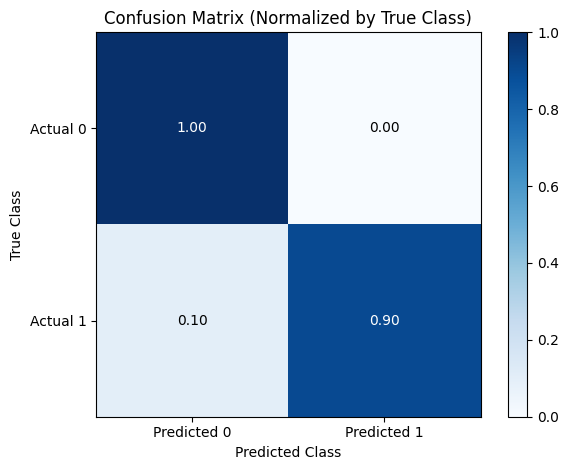

In [7]:
# Normalized Confusion Matrix

# 'cm' is already computed in the previous cell:
# cm = confusion_matrix(yc_te, yc_pred_te)

# Row-wise normalization (relative to the true class)
# cm.sum(axis=1, keepdims=True) computes the sum of each row
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

# --- Plot ---
fig, ax = plt.subplots()

# Display matrix as heatmap
im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(im)

# Axis settings
ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=['Predicted 0', 'Predicted 1'],
    yticklabels=['Actual 0', 'Actual 1'],
    title="Confusion Matrix (Normalized by True Class)",
    ylabel='True Class',
    xlabel='Predicted Class'
)

# Insert numeric values (percentages) in each cell
thresh = cm_norm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, f"{cm_norm[i, j]:.2f}",
            ha="center", va="center",
            color="white" if cm_norm[i, j] > thresh else "black"
        )

fig.tight_layout()
plt.show()


## ROC Curve and ROC-AUC

This is one of the most important evaluation tools for binary classification.

### What Is a Threshold?

Our model does not directly output `0` or `1`. It first produces a **score** (via the `decision_function`). By default:

* If `score >= 0`, predict class `1`
* If `score < 0`, predict class `0`

What happens if we shift this threshold?

* **High threshold (e.g., +2.0):**  
  The model is very "conservative" when predicting `1`. It will make few False Positives (FP), but it will also miss many true positives (high FN).  
  **Result:** High Precision, low Recall.

* **Low threshold (e.g., –2.0):**  
  The model will predict `1` for almost everything. It will find nearly all true positives (high Recall), but generate many false alarms (high FP).  
  **Result:** Low Precision, high Recall.

### ROC Curve

The **ROC (Receiver Operating Characteristic)** curve visualizes this *trade-off* across **all possible thresholds**.

* **Y-axis:** **True Positive Rate (TPR)** — same as **Recall**  
  $$TPR = \frac{TP}{TP + FN}$$  
  ("What percentage of actual positives did we correctly identify?")

* **X-axis:** **False Positive Rate (FPR)**  
  $$FPR = \frac{FP}{FP + TN}$$  
  ("What percentage of negatives did we incorrectly flag as positive?")

### How to Read the ROC Curve

* **Perfect model:** Curve hugs the top-left corner (TPR = 1.0, FPR = 0).  
  Means: There exists a threshold where the model finds all positives without any false alarms.
* **Our model (orange curve):**  
  Shows how FPR increases as we push TPR higher.
* **Random baseline (dashed diagonal):**  
  Represents a coin-flip classifier. The model must perform significantly above this line.

### What Is ROC-AUC?

**AUC = Area Under the Curve.**

It compresses the entire ROC curve into a single number:

| AUC Value | Interpretation          |
|-----------|-------------------------|
| **1.0**   | Perfect classifier      |
| **0.9+**  | Excellent               |
| **0.8–0.9** | Very good              |
| **0.7–0.8** | Decent                 |
| **0.5**   | Random guessing         |

**Key idea:**  
AUC measures how well the model **ranks** samples, not just the final `0/1` decisions.

> "What is the probability that a randomly chosen positive sample receives a higher score than a randomly chosen negative sample?"

$$\phantom{}$$


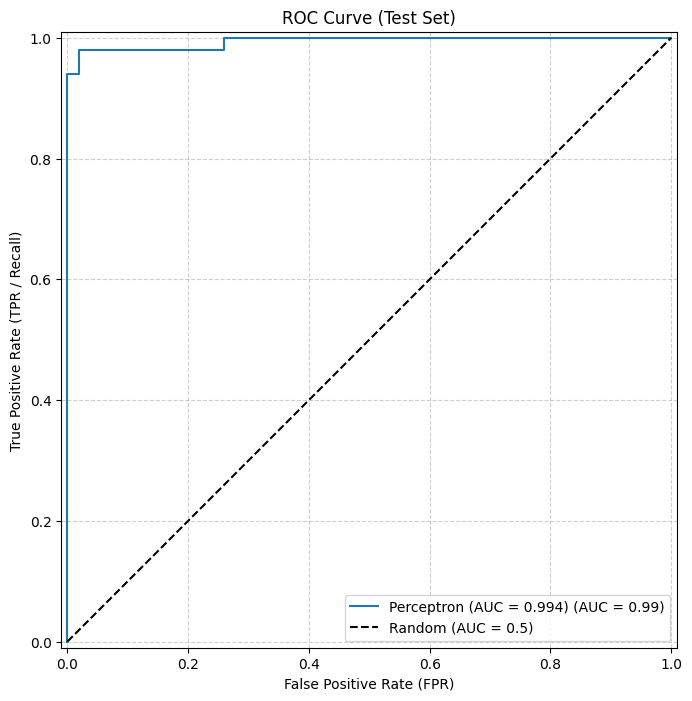

In [8]:
# Code for ROC Curve

# We already have:
#  - 'scores_te' (raw scores from decision_function)
#  - 'yc_te' (true labels)
#  - 'roc_auc' (computed AUC)

plt.figure(figsize=(8, 8))

# Use RocCurveDisplay for convenience
# 'from_predictions' takes the true labels and predicted scores
RocCurveDisplay.from_predictions(
    yc_te,
    scores_te,
    name=f"Perceptron (AUC = {roc_auc:.3f})",
    ax=plt.gca()  # gca = "get current axis"
)

# Add diagonal reference line (random model)
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.5)")

plt.title("ROC Curve (Test Set)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR / Recall)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Precision–Recall Curve (PR Curve)

The ROC–AUC curve is great, but it has one “weakness”: it can be overly optimistic on **highly imbalanced datasets**.

**Problem:** On the ROC curve, the X-axis is the False Positive Rate \((FPR = \frac{FP}{FP + TN})\).  
If you have 1,000,000 negatives (TN) and only 100 positives (TP), even 10,000 false alarms (FP) yield a *very low* FPR \((10{,}000 / 1{,}000{,}000 = 0.01)\).  
The model can look excellent on ROC, even though it produces 100× more false alarms than the number of true positives.

### PR Curve

The Precision–Recall (PR) curve addresses this issue. It shows the same threshold **trade-off**, but with:

* **Y-axis:** **Precision**  
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$  
  (What percentage of *predicted positives* were correct?)

* **X-axis:** **Recall** (a.k.a. TPR)  
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$  
  (What percentage of *actual positives* did we find?)

### How to read a PR curve

* **Ideal model:** The curve hugs the top-right corner (Precision = 1.0, Recall = 1.0).  
  This means the model finds all positives without any false alarms.
* **Random baseline (dashed):** A horizontal line at the **prevalence** (fraction of positives).  
  (e.g., if 10% of the data are positive, a random classifier has Precision ≈ 0.1.)
* **Trade-off:** As you push **Recall** higher (by lowering the threshold), you typically **lose Precision** (FP increases).

### What is AP?

**AP = Average Precision** (also called PR–AUC). It is the area under the PR curve.  
Like ROC–AUC, it summarizes the entire curve into a single number. It is preferred for **imbalanced datasets**, where we primarily care about the minority (positive) class.

$$\phantom{}$$


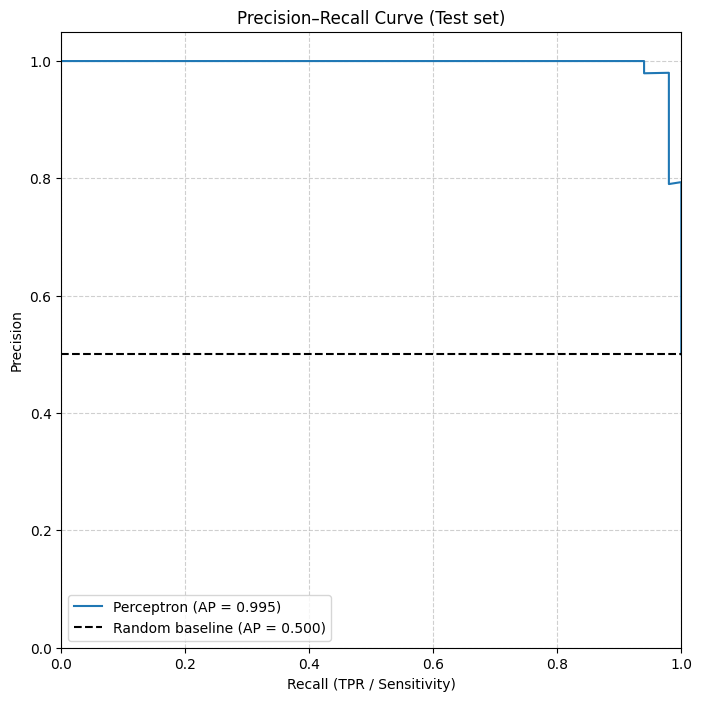

In [9]:
# Code for PR curve

from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute PR curve points
# precision, recall, thresholds = precision_recall_curve(y_true, scores)
pr, rc, _ = precision_recall_curve(yc_te, scores_te)

# Compute area under the PR curve (Average Precision)
ap = average_precision_score(yc_te, scores_te)

plt.figure(figsize=(8, 8))

# Plot PR curve
plt.plot(rc, pr, label=f"Perceptron (AP = {ap:.3f})")

# Add baseline of a random classifier
# (level = proportion of the positive class)
random_baseline = np.mean(yc_te)
plt.axhline(random_baseline, color='k', linestyle='--',
            label=f"Random baseline (AP = {random_baseline:.3f})")

plt.title("Precision–Recall Curve (Test set)")
plt.xlabel("Recall (TPR / Sensitivity)")
plt.ylabel("Precision")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.05)
plt.show()


## Stratified K-Fold Cross-Validation

Just like in regression, a simple `train/val/test` split is subject to randomness.  
In classification it’s even worse — what if the validation split happens to contain only “easy” examples?

We therefore use **Stratified K-Fold CV**. It works like standard K-Fold CV, with one key improvement: **each fold preserves the same class proportions** as in the full dataset.

This is essential for imbalanced datasets.

**Key rule (preventing Data Leakage):** The scaler must **always be fit anew inside each fold** using only that fold’s training split.


In [10]:
# Implementing Stratified K-Fold CV

from sklearn.model_selection import StratifiedKFold

# For CV, use the original unscaled data
# (combine training and validation sets; keep the test set aside)
X_cv_data = np.vstack((Xc_tr, Xc_va))
y_cv_data = np.concatenate((yc_tr, yc_va))

# Initialize the Stratified K-Fold splitter
# Important: 'shuffle=True' is good practice
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSTATE)

cv_acc_scores = []
cv_f1_scores = []
cv_roc_auc_scores = []
fold_counter = 1

print("Starting 5-Fold Stratified Cross-Validation...")
# Loop over 5 folds
# The .split() method needs both X and y to stratify by y
for tr_idx, va_idx in skf.split(X_cv_data, y_cv_data):
    # 1. Split data into the current fold
    Xtr_fold, Xva_fold = X_cv_data[tr_idx], X_cv_data[va_idx]
    ytr_fold, yva_fold = y_cv_data[tr_idx], y_cv_data[va_idx]

    # 2. FIT THE SCALER ONLY ON THE TRAIN SPLIT OF THE FOLD
    sc_fold = StandardScaler().fit(Xtr_fold)

    # 3. Transform both splits
    Xtr_s_fold = sc_fold.transform(Xtr_fold)
    Xva_s_fold = sc_fold.transform(Xva_fold)

    # 4. Train the model (without Early Stopping, fixed number of epochs)
    mdl_fold = PerceptronClassifier(n_epochs=100, lr=0.01)
    mdl_fold.fit(Xtr_s_fold, ytr_fold)  # Train without a validation split

    # 5. Evaluate on the validation fold
    y_pred_fold = mdl_fold.predict(Xva_s_fold)
    # For ROC–AUC we need scores
    y_scores_fold = mdl_fold.decision_function(Xva_s_fold)

    # Store metrics
    acc = accuracy_score(yva_fold, y_pred_fold)
    f1 = f1_score(yva_fold, y_pred_fold, zero_division=0)
    roc_auc = roc_auc_score(yva_fold, y_scores_fold)

    print(f"  Fold {fold_counter}/5 | Acc: {acc:.3f} | F1: {f1:.3f} | ROC-AUC: {roc_auc:.3f}")

    cv_acc_scores.append(acc)
    cv_f1_scores.append(f1)
    cv_roc_auc_scores.append(roc_auc)
    fold_counter += 1

# --- Final CV result ---
print("---" * 10)
print("Stratified K-Fold CV result (mean of 5 folds):")
print(f"  Mean Accuracy: {np.mean(cv_acc_scores):.3f} (± {np.std(cv_acc_scores):.3f})")
print(f"  Mean F1-Score: {np.mean(cv_f1_scores):.3f} (± {np.std(cv_f1_scores):.3f})")
print(f"  Mean ROC–AUC:  {np.mean(cv_roc_auc_scores):.3f} (± {np.std(cv_roc_auc_scores):.3f})")


Starting 5-Fold Stratified Cross-Validation...
Perceptron training starts (max 100 epochs, lr=0.01)...
INFO: Training finished (reached max epochs).
  Fold 1/5 | Acc: 0.912 | F1: 0.914 | ROC-AUC: 0.979
Perceptron training starts (max 100 epochs, lr=0.01)...
INFO: Training finished (reached max epochs).
  Fold 2/5 | Acc: 0.912 | F1: 0.916 | ROC-AUC: 0.966
Perceptron training starts (max 100 epochs, lr=0.01)...
INFO: Training finished (reached max epochs).
  Fold 3/5 | Acc: 0.912 | F1: 0.916 | ROC-AUC: 0.981
Perceptron training starts (max 100 epochs, lr=0.01)...
INFO: Training finished (reached max epochs).
  Fold 4/5 | Acc: 0.925 | F1: 0.929 | ROC-AUC: 0.991
Perceptron training starts (max 100 epochs, lr=0.01)...
INFO: Training finished (reached max epochs).
  Fold 5/5 | Acc: 0.887 | F1: 0.897 | ROC-AUC: 0.983
------------------------------
Stratified K-Fold CV result (mean of 5 folds):
  Mean Accuracy: 0.910 (± 0.012)
  Mean F1-Score: 0.914 (± 0.010)
  Mean ROC–AUC:  0.980 (± 0.008)


## Comparison with Scikit-learn Models

Our hand-built `PerceptronClassifier` is great for understanding first principles.  
In practice, we use optimized and more robust implementations from `scikit-learn`.

For linear classification, two key options are:

* **`LogisticRegression`**
  * **What it is:** Despite the name, this is a **classification** model. It is the most widely used and fundamental linear classifier.
  * **How it works:** Instead of the perceptron’s step function, it uses the **sigmoid (logistic) function**, which returns a continuous probability in \([0,1]\).
  * **Advantage:** More stable training via a **smooth loss** (log loss / cross-entropy), and the probabilistic output is often more useful than a hard `0/1`.

* **`SGDClassifier`**
  * **What it is:** A flexible wrapper that trains various linear models (including the perceptron) using **Stochastic Gradient Descent (SGD)**.
  * **How to use:**
    * `SGDClassifier(loss='perceptron')`: A near-equivalent to our perceptron.
    * `SGDClassifier(loss='log_loss')`: A logistic-regression–style classifier trained with SGD (great for large datasets).
    * `SGDClassifier(loss='hinge')`: A **linear SVM–style** classifier (hinge loss).
  * **Advantage:** Extremely fast and scalable to massive datasets that don’t fit in memory.

Let’s compare our model to `LogisticRegression` and to `SGDClassifier(loss='perceptron')`.


In [11]:
## Code to compare with Scikit-learn

# We use a Pipeline to ensure scikit-learn models
# are trained on properly scaled data.

# --- Model 1: Logistic Regression ---
# 'solver="lbfgs"' is a standard, robust choice
# 'max_iter=500' to ensure convergence
pipe_logreg = Pipeline([
    ('scale', StandardScaler()),
    ('model', LogisticRegression(solver='lbfgs', max_iter=500, random_state=RSTATE))
])
pipe_logreg.fit(Xc_tr, yc_tr)  # Train on the original (unscaled) data; scaler is inside the pipeline
y_pred_logreg = pipe_logreg.predict(Xc_te)
# For ROC–AUC we need class-1 probabilities
y_scores_logreg = pipe_logreg.predict_proba(Xc_te)[:, 1]

# --- Model 2: SGDClassifier (Perceptron) ---
# 'loss="perceptron"': request a perceptron-like update rule
# 'early_stopping=True, n_iter_no_change=15': built-in early stopping
# 'max_iter=2000': maximum number of epochs
pipe_sgd_perc = Pipeline([
    ('scale', StandardScaler()),
    ('model', SGDClassifier(loss='perceptron', max_iter=2000,
                            early_stopping=True, n_iter_no_change=15,
                            random_state=RSTATE))
])
pipe_sgd_perc.fit(Xc_tr, yc_tr)
y_pred_sgd = pipe_sgd_perc.predict(Xc_te)
# SGD Perceptron exposes a decision_function suitable for ROC–AUC
y_scores_sgd = pipe_sgd_perc.decision_function(Xc_te)

# --- Metric comparison ---
print("--- Performance comparison on the Test set ---")
print("Metric            | Our model | LogisticReg | SGD Perceptron")
print("------------------|-----------|-------------|----------------")
print(f"Accuracy:         | {acc:.3f}     | {accuracy_score(yc_te, y_pred_logreg):.3f}        | {accuracy_score(yc_te, y_pred_sgd):.3f}")
print(f"F1-Score:         | {f1:.3f}     | {f1_score(yc_te, y_pred_logreg):.3f}        | {f1_score(yc_te, y_pred_sgd):.3f}")
print(f"ROC-AUC:          | {roc_auc:.3f}     | {roc_auc_score(yc_te, y_scores_logreg):.3f}        | {roc_auc_score(yc_te, y_scores_sgd):.3f}")

# All three linear models should yield similar (and high) performance
# because the data are linearly separable.


--- Performance comparison on the Test set ---
Metric            | Our model | LogisticReg | SGD Perceptron
------------------|-----------|-------------|----------------
Accuracy:         | 0.887     | 0.950        | 0.860
F1-Score:         | 0.897     | 0.947        | 0.837
ROC-AUC:          | 0.983     | 0.994        | 0.994


## When Linear Classifiers Fail (The XOR Problem)

Our Perceptron (as well as Logistic Regression and linear SVM) worked well because the data were **linearly separable** — a single straight line was sufficient to separate the classes.

But what happens when the data are **not** linearly separable?

The most famous example is the **XOR problem** (Exclusive OR).  
In this scenario, data points are arranged in a “cross” pattern.

No matter how hard you try, **you cannot draw a *single straight line*** that correctly separates the blue points from the orange points.

Linear models fail completely on this task. Their accuracy will be around **50%**, which is no better than random guessing.

Historically, this failure was a major disappointment and nearly **halted neural network research for decades** (since the Perceptron is a single-layer neural network).

To solve XOR, we need **non-linear models**, such as:

* SVM with a non-linear kernel (e.g., RBF)
* Random Forest (decision trees)
* **Multi-Layer Perceptrons (MLPs)** — the basis of modern deep learning, capable of learning non-linear decision boundaries


--- Performance on non-linear data (make_moons) ---
Accuracy: 0.847
The model performs only slightly better than random guessing (50%)...


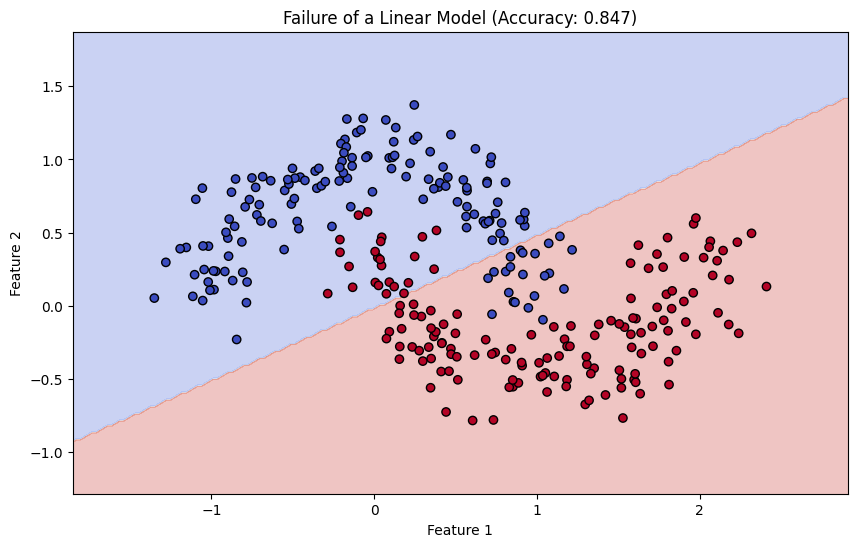

In [12]:
## Failure of a Linear Model on Non-Linear Data

# For demonstration, we use the "make_moons" dataset.
# It generates two interleaving moon-shaped clusters that cannot be separated by a straight line.

# 1. Create non-linear data
X_nl, y_nl = make_moons(n_samples=300, noise=0.15, random_state=RSTATE)

# 2. Create a linear model
# We use a Pipeline with an SGD Perceptron
pipe_fail = Pipeline([
    ('scale', StandardScaler()),
    ('model', SGDClassifier(loss='perceptron', max_iter=1000, random_state=RSTATE))
])

# 3. Train
pipe_fail.fit(X_nl, y_nl)

# 4. Evaluate
y_pred_fail = pipe_fail.predict(X_nl)
acc_fail = accuracy_score(y_nl, y_pred_fail)

print(f"--- Performance on non-linear data (make_moons) ---")
print(f"Accuracy: {acc_fail:.3f}")
print("The model performs only slightly better than random guessing (50%)...")


# 5. Visualize the failure (same logic as in an earlier cell)
x0_min, x0_max = X_nl[:, 0].min() - 0.5, X_nl[:, 0].max() + 0.5
x1_min, x1_max = X_nl[:, 1].min() - 0.5, X_nl[:, 1].max() + 0.5
xx0, xx1 = np.meshgrid(np.linspace(x0_min, x0_max, 200),
                       np.linspace(x1_min, x1_max, 200))
grid_points = np.c_[xx0.ravel(), xx1.ravel()]

# Get predictions from the trained pipeline
zz = pipe_fail.predict(grid_points).reshape(xx0.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx0, xx1, zz, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_nl[:, 0], X_nl[:, 1], c=y_nl,
            cmap=plt.cm.coolwarm, edgecolors='k')

plt.title(f"Failure of a Linear Model (Accuracy: {acc_fail:.3f})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# The plot clearly shows that a single straight line cannot separate these data.
